This notebook simulates the gain of a JTWPA architecture.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
pi = np.pi

In [2]:
Zchar = 50 #Ohms

In [122]:
class GainSimulation():

    def __init__(self, RPM, a, N, Cj, L, C, Cc, Cr, Lr, I_P, I_0, omega_p, omega_s, generalize=False):
        self.RPM = RPM
        self.a = a
        self.N = N
        self.Cj = Cj
        self.L = L
        self.C = C
        self.Cc = Cc
        self.Cr = Cr
        self.Lr = Lr
        self.I_0 = I_0
        self.I_P = I_P
        self.omega_p = omega_p * 2 * pi
        self.omega_s = omega_s * 2 * pi
        self.generalize = generalize

        self.update_system()



    # Some helpful class functions

    def init_signal_amp(self):
         return self.I_P * Zchar / self.omega_p
    
    def get_impedences(self, omega):
        Z1 = (1 / 1j / omega / self.L + 1j * omega * self.Cj) ** -1
        Zres = (1 - (self.Cc + self.Cr) * self.Lr * omega ** 2) / 1j / omega / self.Cc / (1 - self.Cr * self.Lr * omega ** 2)
        Zc = -1j / omega / self.C
        Z2 = (1 / Zc + 1 / Zres) ** -1
        return {'Z1':Z1, 'Z2':Z2}
    
    def C0(self, omega):
        return 1 / 1j / omega / self.get_impedences(omega)['Z2']
    
    def dispersion_relation(self, omega):
        return np.arccos( 1 + self.get_impedences(omega)['Z1'] / self.get_impedences(omega)['Z2'] / 2 )
       


    # Set local parameters based on init values
    
    def set_idler(self):
        self.omega_i = 2*self.omega_p - self.omega_s
    
    def set_ks(self):
        self.k_p = self.dispersion_relation(self.omega_p)
        self.k_s = self.dispersion_relation(self.omega_s)
        self.k_i = self.dispersion_relation(self.omega_i)

    def set_pump_current(self):
        if self.RPM:
            gamma = -self.k_p ** 3 / self.omega_p ** 2 / self.C0(self.omega_p) + self.k_s ** 3 / self.omega_s ** 2 / self.C0(self.omega_s) + self.k_i / self.omega_i ** 2 / self.C0(self.omega_i)
            dk_l = 2*self.k_p - self.k_s - self.k_i
            self.I_P = self.I_0 * self.omega_p * np.sqrt(8 * self.L ** 3 / self.a ** 4 / self.k_p ** 2 / Zchar / np.conjugate(Zchar) * dk_l / gamma)

    def set_kappas(self):
        if self.generalize:
            self.kappa = complex(self.a ** 2 * self.k_p ** 2 * abs(Zchar) ** 2 / 16 / self.L ** 2 / self.omega_p ** 2 * (self.I_P/self.I_0) ** 2)
            self.kappa_i = complex(self.a ** 2 * self.kappa * (2 * self.k_p - self.k_s) * self.k_s * self.k_i * 1j * self.get_impedences(self.omega_i)['Z2'] / self.L / self.omega_i)
            self.kappa_s = complex(self.a ** 2 * self.kappa * (2 * self.k_p - self.k_i) * self.k_s * self.k_i * 1j * self.get_impedences(self.omega_s)['Z2'] / self.L / self.omega_s)
        else:
            self.kappa = complex(self.a ** 2 * self.k_p ** 2 * self.init_signal_amp() * np.conjugate(self.init_signal_amp()) / 16 / self.I_0 ** 2 / self.L ** 2)
            self.kappa_i = complex(self.a ** 2 * self.kappa * (2 * self.k_p - self.k_s) * self.k_s * self.k_i / self.L / self.C0(self.omega_i) / self.omega_i ** 2)
            self.kappa_s = complex(self.a ** 2 * self.kappa * (2 * self.k_p - self.k_i) * self.k_s * self.k_i / self.L / self.C0(self.omega_s) / self.omega_s ** 2)
    
    def set_alphas(self):
        self.alpha_p = complex(self.kappa * self.k_p ** 3 / self.L / self.C0(self.omega_p) / self.omega_p ** 2 * self.a ** 2)
        self.alpha_i = complex(2 * self.kappa * self.k_i ** 3 / self.L / self.C0(self.omega_i) / self.omega_i ** 2 * self.a ** 2)
        self.alpha_s = complex(2 * self.kappa * self.k_s ** 3 / self.L / self.C0(self.omega_s) / self.omega_s ** 2 * self.a ** 2)
    
    def set_mismatch(self):
        self.dk = 2 * self.k_p - self.k_s - self.k_i + 2 * self.alpha_p - self.alpha_s - self.alpha_i

    # Sets 'gain coefficient' as described by the RPM paper - used in wave function solution below
    def set_g(self):
        self.g = np.sqrt(self.kappa_s * np.conjugate(self.kappa_i) - (self.dk / 2) ** 2)



    # The gain function assumed for plotting -- does not plot well
    def gain(self):
        return 20 * np.log10(self.as_x(self.N * self.a))



    # Solution to wave function (Eq. 24 in Appendix A of RPM paper, idle and signal incident amplitude are set arbitrarily)
    def as_x(self, x_range):

        as_x_values = (
            (( np.cosh(self.g * x_range) - 1j * self.dk / 2 / self.g * np.sinh(self.g * x_range)) +
            0j * self.kappa_i / self.g * np.sinh(self.g * x_range)) * np.exp(1j * self.dk * x_range / 2)
        )

        return as_x_values



    # (beta) May be used ot visualize the pump_wave
    def pump_wave(self, x):
        return self.init_signal_amp() * np.exp(1j * self.alpha_p * x)
    
    # def signal_wave(self, x):
    #     return self.alpha_s * np.exp(1j * self.alpha_s * x)
    
    # def idle_wave(self, x):
    #     return self.alpha_i * np.exp(1j * self.alpha_i * x)



    # Function called to update simulation each iteration
    def update_system(self):
        self.set_idler()
        self.set_ks()
        self.set_pump_current()
        self.set_kappas()
        self.set_alphas()
        self.set_mismatch()
        self.set_g()



    # Plotting functions

    def plot_dispersion(self, omega_s_range):
        ks_values = []
        for omega_s in omega_s_range:
            self.omega_s = omega_s * 2 * pi
            self.update_system()
            ks_values.append(self.k_s)
        
        plt.figure(figsize=(8, 6))
        plt.plot(omega_s_range, ks_values, label='k vs 'r'$\omega$')
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('k')
        plt.title('Wavevector vs Frequency')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_dk_vs_omega_s(self, omega_s_range):
        dk_values = []
        for omega_s in omega_s_range:
            self.omega_s = omega_s * 2 * pi
            self.update_system()
            dk_values.append(self.dk)
        
        plt.figure(figsize=(8, 6))
        plt.plot(omega_s_range, dk_values, label=r'$\Delta$k vs $\omega_s$')
        #plt.ylim([-0.005,0.005])
        plt.xlabel('omega_s')
        plt.ylabel(r'$\Delta$k (a$^{-1}$)')
        plt.title(r'$\Delta$k vs $\omega_s$')
        plt.grid(True)
        plt.legend()
        plt.show()

    def gain_vs_omega_s(self, omega_s_range):
        gain_values = []
        for omega_s in omega_s_range:
            self.omega_s = omega_s * 2 * pi
            self.update_system()
            gain_values.append(self.gain())
        
        plt.figure(figsize=(8, 6))
        plt.plot(omega_s_range, gain_values, label='Gain vs ' +r'$\omega_s$')
        #plt.ylim([0,0.2])
        plt.xlabel(r'$\omega_s$')
        plt.ylabel('Gain')
        plt.title('Gain vs ' +r'$\omega_s$')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_as_x(self, x_range):
        as_x_values = self.as_x(x_range)

        plt.figure(figsize=(8, 6))
        plt.plot(x_range, np.real(as_x_values), label='Real part of as(x)')
        #plt.plot(x_range, np.imag(as_x_values), label='Imaginary part of as(x)')
        plt.xlabel('x')
        plt.ylabel('Signal Wave')
        plt.title('Wave Amplitude over Distance')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_waves_vs_x(self, x_range):
        pump_vs_x_values = self.pump_wave(x_range)

        plt.figure(figsize=(8, 6))
        plt.plot(x_range, np.real(pump_vs_x_values), label='Real part of pump')
        #plt.plot(x_range, np.imag(pump_vs_x_values), label='Imaginary part of as(x)')
        plt.xlabel('x')
        plt.ylabel('as(x)')
        plt.title('Wave Envelope over 1 Unit Cell')
        plt.grid(True)
        plt.legend()
        plt.show()

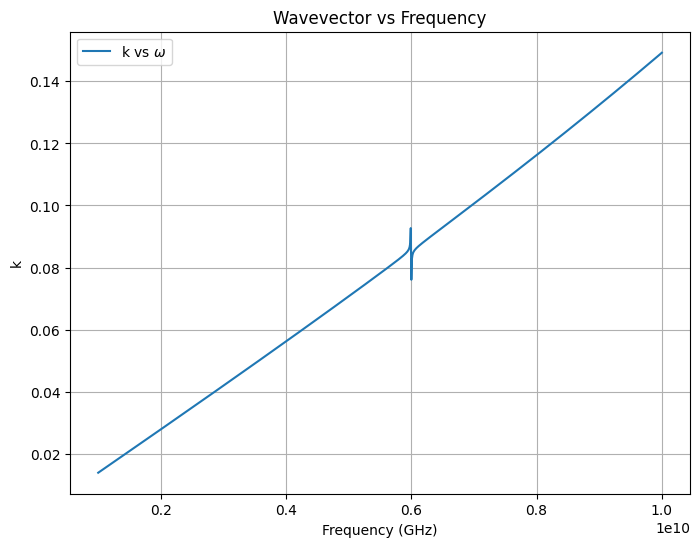

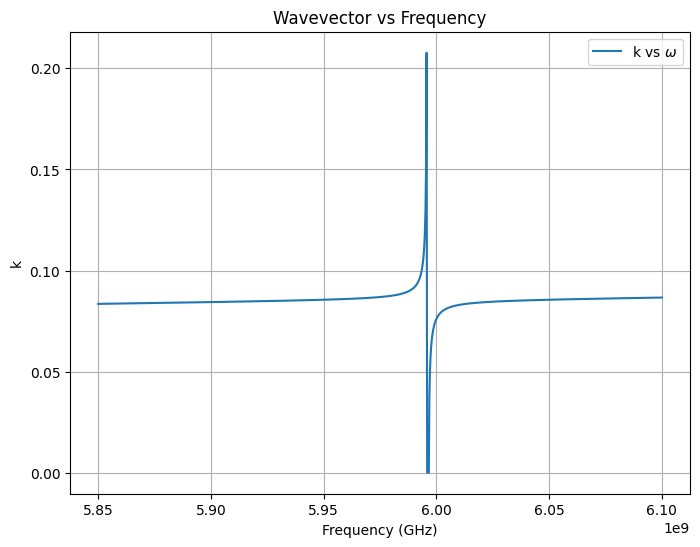

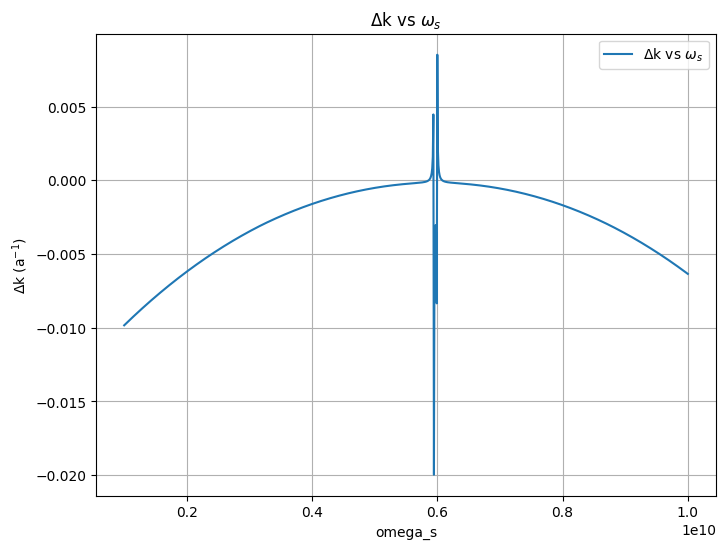

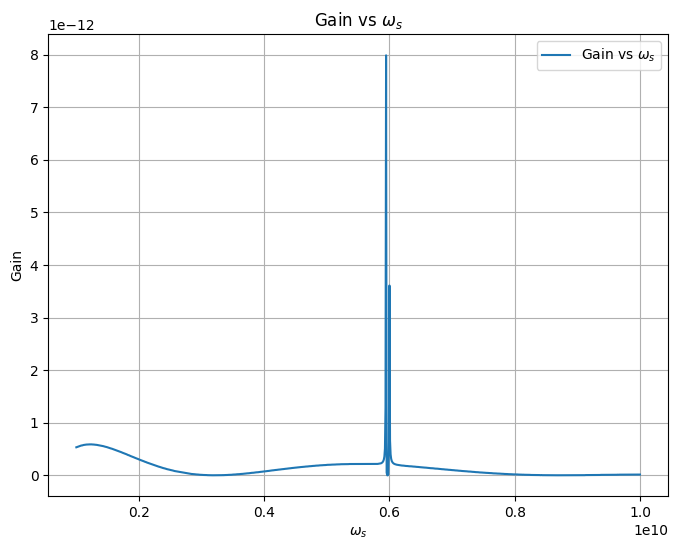

In [123]:
# Class instance based on RPM paper
sim = GainSimulation(RPM = True, a=1e-5, N=2000, Cj = 329e-15, L=100e-12, C=39e-15, Cc=10e-15, Cr=7.036e-12, Lr=100e-12, I_P=0.5*3.29e-6, I_0 = 3.29e-6, omega_p=5.97e9, omega_s=5.97e9, generalize=False)

#Plotting over freq
omega_s_range = np.linspace(1e9, 10e9, 1000)

sim.plot_dispersion(omega_s_range)
sim.plot_dispersion(np.linspace(5.85e9, 6.1e9, 1000))

# Plot dk as a function of omega_p
sim.plot_dk_vs_omega_s(omega_s_range)

# Plot gain as a function of omega_p
sim.gain_vs_omega_s(omega_s_range)


#Plotting over amplifier distance
#x_range = np.linspace(0, sim.N*sim.a, 1000)

# Plot as(x)
#sim.plot_as_x(x_range)

#sim.plot_ai_x(x_range)

#sim.plot_waves_vs_x(x_range)

In [53]:
print(1e-9/ np.sqrt(sim.Lr * (sim.Cc + sim.Cr)))

37.67286771245834


In [54]:
h = 6.62607015e-34
q = 1.602176634e-19
phi0 = h / 2 / q
print(1e-9 * np.sqrt(2 * np.pi * sim.I_0 / phi0 / (sim.C+sim.Cj)))
print(1e-9 / np.sqrt(sim.L * (sim.Cj)))

164.81857455740274
174.34201093860167


In [7]:
print(sim.get_impedences(sim.omega_s))

{'Z1': (-0+1.195570124145721j), 'Z2': -1714.916648643081j}
